# Free-Knot Alternating Optimization for $C_{1a}$

Alternates between optimizing heights (Step A) and edge positions (Step B).

- **Step A**: FFT-based LSE continuation + Nesterov on heights (edges fixed)
- **Step B**: L-BFGS-B on interior edge positions (heights fixed)
- Accept/reject logic prevents regression

Best uniform-grid baseline: 1.5092 (P=1000), 1.5098 (P=200)

In [2]:
import os, time, json
import numpy as np
from numba import njit, prange
from scipy.optimize import minimize
import matplotlib.pyplot as plt

print(f'NumPy {np.__version__}')
print(f'CPU cores: {os.cpu_count()}')

NumPy 2.3.5
CPU cores: 16


## Exact Autoconvolution (Numba JIT)

In [3]:
@njit(cache=True)
def _autoconv_at_points(edges, heights, t_values):
    N = len(heights)
    T = len(t_values)
    result = np.zeros(T)
    a = edges[:-1]
    b = edges[1:]
    for ti in range(T):
        t = t_values[ti]
        total = 0.0
        for i in range(N):
            for j in range(N):
                lo = max(a[i], t - b[j])
                hi = min(b[i], t - a[j])
                if hi > lo:
                    total += heights[i] * heights[j] * (hi - lo)
        result[ti] = total
    return result


@njit(parallel=True, cache=True)
def _autoconv_at_points_parallel(edges, heights, t_values):
    N = len(heights)
    T = len(t_values)
    result = np.zeros(T)
    a = edges[:-1]
    b = edges[1:]
    for ti in prange(T):
        t = t_values[ti]
        total = 0.0
        for i in range(N):
            for j in range(N):
                lo = max(a[i], t - b[j])
                hi = min(b[i], t - a[j])
                if hi > lo:
                    total += heights[i] * heights[j] * (hi - lo)
        result[ti] = total
    return result


def compute_breakpoints(edges):
    bp = (edges[:, None] + edges[None, :]).ravel()
    bp = np.unique(bp)
    return bp[(bp >= 2 * edges[0]) & (bp <= 2 * edges[-1])]


def peak_exact(edges, heights):
    """Exact peak autoconvolution on non-uniform grid."""
    bp = compute_breakpoints(edges)
    if len(bp) > 500:
        conv = _autoconv_at_points_parallel(edges, heights, bp)
    else:
        conv = _autoconv_at_points(edges, heights, bp)
    idx = np.argmax(conv)
    return float(conv[idx]), float(bp[idx])


# Warm up JIT
_e = np.linspace(-0.25, 0.25, 11)
_h = np.ones(10) * 2.0
_bp = compute_breakpoints(_e)
_ = _autoconv_at_points(_e, _h, _bp[:5])
_ = _autoconv_at_points_parallel(_e, _h, _bp)
p, t = peak_exact(_e, _h)
print(f'Uniform f=2 on [-0.25,0.25]: peak={p:.6f} at t={t:.4f} (expect 2.0 at 0.0)')

Uniform f=2 on [-0.25,0.25]: peak=2.000000 at t=0.0000 (expect 2.0 at 0.0)


## FFT-Based LSE Objective and Gradient

For height optimization on non-uniform grids, we sample $f$ on a fine uniform FFT grid,
compute the autoconvolution via FFT, and derive the LSE gradient analytically through
cross-correlation. All operations are $O(N \log N)$ regardless of the number of bins $P$.

In [4]:
N_FFT = 8192


def fft_peak(edges, heights, n_fft=N_FFT):
    """FFT-based approximate peak autoconvolution."""
    dx = 0.5 / n_fft
    x_grid = -0.25 + np.arange(n_fft) * dx
    bin_idx = np.searchsorted(edges[1:-1], x_grid)
    f_padded = np.zeros(2 * n_fft)
    f_padded[:n_fft] = heights[bin_idx]
    F = np.fft.rfft(f_padded)
    autoconv = np.fft.irfft(F * F) * dx
    return float(np.max(autoconv))


def fft_lse_obj_grad(masses, edges, widths, beta, bin_idx, n_fft=N_FFT):
    """FFT-based LSE objective and gradient w.r.t. mass variables.
    
    masses: simplex weights m_i = h_i * w_i, sum(m) = 1
    Returns (lse_value, gradient_wrt_masses)
    """
    P = len(masses)
    dx = 0.5 / n_fft
    heights = masses / widths

    # Sample step function on FFT grid
    f_padded = np.zeros(2 * n_fft)
    f_padded[:n_fft] = heights[bin_idx]

    # Autoconvolution via FFT
    F = np.fft.rfft(f_padded)
    autoconv = np.fft.irfft(F * F) * dx

    # LSE objective (numerically stable)
    bc = beta * autoconv
    bc_max = bc.max()
    exp_bc = np.exp(bc - bc_max)
    sum_exp = exp_bc.sum()
    lse = bc_max / beta + np.log(sum_exp) / beta

    # Softmax weights
    softmax = exp_bc / sum_exp

    # Gradient via cross-correlation: r[k] = sum_m softmax[m] * f[m-k]
    S = np.fft.rfft(softmax)
    R = np.fft.irfft(np.conj(F) * S)

    # Accumulate gradient per bin: grad_h[i] = 2*dx * sum_{k in bin i} R[k]
    grad_h = 2.0 * dx * np.bincount(bin_idx, weights=R[:n_fft], minlength=P)
    # Convert to mass gradient: grad_m[i] = grad_h[i] / w_i
    grad_m = grad_h / widths

    return lse, grad_m


def fft_lse_obj_only(masses, edges, widths, beta, bin_idx, n_fft=N_FFT):
    """LSE objective only (no gradient), for Armijo line search."""
    dx = 0.5 / n_fft
    heights = masses / widths
    f_padded = np.zeros(2 * n_fft)
    f_padded[:n_fft] = heights[bin_idx]
    F = np.fft.rfft(f_padded)
    autoconv = np.fft.irfft(F * F) * dx
    bc = beta * autoconv
    bc_max = bc.max()
    return bc_max / beta + np.log(np.sum(np.exp(bc - bc_max))) / beta


# Validate gradient with finite differences
np.random.seed(42)
_P = 10
_edges = np.linspace(-0.25, 0.25, _P + 1)
_widths = np.diff(_edges)
_m = np.random.dirichlet(np.ones(_P))
_dx = 0.5 / N_FFT
_x_grid = -0.25 + np.arange(N_FFT) * _dx
_bin_idx = np.searchsorted(_edges[1:-1], _x_grid)
_beta = 10.0

_lse, _grad = fft_lse_obj_grad(_m, _edges, _widths, _beta, _bin_idx)
_eps = 1e-6
_grad_fd = np.zeros(_P)
for i in range(_P):
    mp = _m.copy(); mp[i] += _eps
    mm = _m.copy(); mm[i] -= _eps
    fp = fft_lse_obj_only(mp, _edges, _widths, _beta, _bin_idx)
    fm = fft_lse_obj_only(mm, _edges, _widths, _beta, _bin_idx)
    _grad_fd[i] = (fp - fm) / (2 * _eps)

print(f'Gradient check: max error = {np.max(np.abs(_grad - _grad_fd)):.2e}')
print('FFT-based LSE defined.')

Gradient check: max error = 5.98e-10
FFT-based LSE defined.


## Simplex Projection

In [5]:
@njit(cache=True)
def project_simplex(x):
    """Project x onto the probability simplex."""
    n = len(x)
    u = np.sort(x)[::-1]
    cssv = np.cumsum(u) - 1.0
    rho = 0
    for i in range(n):
        if u[i] * (i + 1) > cssv[i]:
            rho = i
    tau = cssv[rho] / (rho + 1.0)
    out = np.empty(n)
    for i in range(n):
        out[i] = max(x[i] - tau, 0.0)
    return out


# Warm up
_ = project_simplex(np.ones(5) / 5.0)
print('Simplex projection ready.')

Simplex projection ready.


## Step A: Height Optimizer (FFT-based LSE Continuation)

In [6]:
BETA_SCHEDULE = [4, 8, 15, 30, 60, 100, 200, 400, 800, 1500]


def optimize_heights(edges, heights_init, n_restarts=5,
                     n_iters_per_beta=3000, start_beta=None, verbose=True):
    """Step A: Optimize heights with fixed edges via FFT-based LSE continuation.
    
    Works in mass variables m_i = h_i * w_i on the simplex.
    start_beta: if set, skip beta stages below this value (useful for warm starts).
    Returns (best_exact_peak, best_heights).
    """
    P = len(heights_init)
    widths = np.diff(edges)

    # Precompute bin assignments for FFT grid (fixed for all restarts)
    dx = 0.5 / N_FFT
    x_grid = -0.25 + np.arange(N_FFT) * dx
    bin_idx = np.searchsorted(edges[1:-1], x_grid)

    m_init = heights_init * widths  # initial masses
    if m_init.sum() > 0:
        m_init /= m_init.sum()
    else:
        m_init = np.ones(P) / P

    # Filter beta schedule for warm starts
    betas = BETA_SCHEDULE
    if start_beta is not None:
        betas = [b for b in BETA_SCHEDULE if b >= start_beta]

    best_exact = np.inf
    best_heights = heights_init.copy()

    for restart in range(n_restarts):
        # Initialize masses
        if restart == 0:
            m = m_init.copy()
        elif restart <= n_restarts // 3:
            # Perturb current best
            noise = 0.3 * np.random.randn(P) * np.mean(m_init)
            m = np.maximum(m_init + noise, 0.0)
            m /= m.sum()
        else:
            # Random Dirichlet
            m = np.random.dirichlet(np.ones(P))

        # LSE beta-continuation with Nesterov + Armijo
        for beta in betas:
            y = m.copy()
            m_prev = m.copy()
            alpha = 0.01
            best_stage_val = np.inf
            best_stage_m = m.copy()
            no_improve = 0

            for it in range(n_iters_per_beta):
                lse, grad = fft_lse_obj_grad(y, edges, widths, beta, bin_idx)

                # Armijo backtracking
                for _ in range(20):
                    m_trial = project_simplex(y - alpha * grad)
                    lse_trial = fft_lse_obj_only(m_trial, edges, widths, beta, bin_idx)
                    descent = np.dot(grad, y - m_trial)
                    if descent > 0 and lse_trial <= lse - 1e-4 * descent:
                        break
                    alpha *= 0.5
                else:
                    m_trial = project_simplex(y - alpha * grad)

                m_new = m_trial
                alpha = min(alpha * 2.0, 0.1)

                # Nesterov momentum
                momentum = it / (it + 3.0)
                y_new = project_simplex(m_new + momentum * (m_new - m_prev))

                m_prev = m_new
                m = m_new
                y = y_new

                # Track best by FFT peak (fast proxy for true max)
                h_trial = m / widths
                peak_fft = fft_peak(edges, h_trial)
                if peak_fft < best_stage_val:
                    best_stage_val = peak_fft
                    best_stage_m = m.copy()
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve > 200:
                    break

            m = best_stage_m

        # Exact evaluation of this restart's result
        h = m / widths
        ep, _ = peak_exact(edges, h)

        if ep < best_exact:
            best_exact = ep
            best_heights = h.copy()
            if verbose:
                print(f'    Restart {restart}: exact={ep:.6f} <-- best')
        elif verbose:
            print(f'    Restart {restart}: exact={ep:.6f}')

    return best_exact, best_heights


# Quick test at P=10
_e = np.linspace(-0.25, 0.25, 11)
_h = np.ones(10) * 2.0
_val, _hopt = optimize_heights(_e, _h, n_restarts=3, n_iters_per_beta=500, verbose=True)
print(f'P=10 test: {_val:.6f}')

    Restart 0: exact=1.567776 <-- best
    Restart 1: exact=1.572320
    Restart 2: exact=1.582708
P=10 test: 1.567776


## Step B: Edge Optimizer (L-BFGS-B with Differentiable Sampling)

In [7]:
def optimize_edges(edges, heights, maxiter=200, beta_edge=500, verbose=True):
    """Step B: Optimize edge positions with fixed heights.

    Reparametrises edges as cumulative softmax of unconstrained z (inherently
    ordered, positive spacings). Samples f on the FFT grid via differentiable
    linear interpolation at bin boundaries (no searchsorted), so L-BFGS-B
    gets accurate gradients from finite differences.
    Returns (exact_peak, new_edges, new_heights).
    """
    P = len(heights)
    widths_old = np.diff(edges)
    masses = heights * widths_old
    masses /= masses.sum()

    n_fft = N_FFT
    dx = 0.5 / n_fft
    x_grid = -0.25 + np.arange(n_fft) * dx  # fixed FFT grid, precompute once

    # Initial z: log of current spacings (softmax(z)*0.5 recovers widths_old)
    z0 = np.log(np.maximum(widths_old, 1e-15))

    def z_to_edges_heights(z):
        """Convert unconstrained z to (edges, heights, spacings) via softmax."""
        exp_z = np.exp(z - z.max())
        spacings = exp_z / exp_z.sum() * 0.5
        e = np.concatenate([[-0.25], -0.25 + np.cumsum(spacings)])
        h = masses / spacings
        return e, h, spacings

    def sample_step_smooth(e, h, x_grid, transition=dx):
        """Sample step function on x_grid using differentiable sigmoid transitions.

        Instead of hard bin assignment via searchsorted, each bin i contributes
        h[i] * sigmoid((x - e[i]) / tau) * sigmoid((e[i+1] - x) / tau)
        where tau = transition / 4 gives a smooth ramp over ~1 FFT cell.
        This makes the sampled signal a smooth function of edge positions.
        """
        tau = transition / 4.0
        f = np.zeros_like(x_grid)
        for i in range(len(h)):
            # Left sigmoid: turns on at e[i]
            left = 1.0 / (1.0 + np.exp(-(x_grid - e[i]) / tau))
            # Right sigmoid: turns off at e[i+1]
            right = 1.0 / (1.0 + np.exp(-(e[i + 1] - x_grid) / tau))
            f += h[i] * left * right
        return f

    def objective(z):
        """FFT-based LSE objective with differentiable bin sampling."""
        e, h, spacings = z_to_edges_heights(z)

        # Differentiable sampling (smooth function of edge positions)
        f_vals = sample_step_smooth(e, h, x_grid)

        f_padded = np.zeros(2 * n_fft)
        f_padded[:n_fft] = f_vals

        # Autoconvolution via FFT
        F = np.fft.rfft(f_padded)
        autoconv = np.fft.irfft(F * F) * dx

        # LSE smoothing (smooth surrogate for max)
        bc = beta_edge * autoconv
        bc_max = bc.max()
        return bc_max / beta_edge + np.log(np.sum(np.exp(bc - bc_max))) / beta_edge

    result = minimize(objective, z0, method='L-BFGS-B',
                      options={'maxiter': maxiter, 'ftol': 1e-12})

    # Reconstruct final solution with hard bin assignment for exact evaluation
    new_edges, new_heights, new_spacings = z_to_edges_heights(result.x)

    # Exact verification
    exact_peak, _ = peak_exact(new_edges, new_heights)
    width_ratio = new_spacings.max() / new_spacings.min()

    if verbose:
        print(f'    L-BFGS-B: lse={result.fun:.6f}, exact={exact_peak:.6f}, '
              f'ratio={width_ratio:.1f}, evals={result.nfev}')

    return exact_peak, new_edges, new_heights


print('Edge optimizer defined.')

Edge optimizer defined.


## Alternating Optimization Loop

In [8]:
def alternating_optimize(P, n_outer=30, n_restarts_a=5,
                         n_iters_per_beta=3000, maxiter_b=200,
                         warm_edges=None, warm_heights=None):
    """Main alternating optimization: heights <-> edges.
    
    Returns dict with best solution and iteration history.
    """
    is_warm = warm_edges is not None and warm_heights is not None

    # Initialize and compute baseline
    if is_warm:
        edges = warm_edges.copy()
        heights = warm_heights.copy()
        best_peak, _ = peak_exact(edges, heights)
        best_edges = edges.copy()
        best_heights = heights.copy()
        print(f'Warm-start baseline: {best_peak:.6f}')
    else:
        edges = np.linspace(-0.25, 0.25, P + 1)
        heights = np.ones(P) * 2.0  # uniform, integral = 1
        best_peak = np.inf
        best_edges = edges.copy()
        best_heights = heights.copy()

    # Initial height optimization
    print(f'Initial Step A (P={P})...')
    t0 = time.time()
    start_beta = 60 if is_warm else None
    peak_a, heights_a = optimize_heights(edges, heights, n_restarts=n_restarts_a,
                                         n_iters_per_beta=n_iters_per_beta,
                                         start_beta=start_beta)
    print(f'  Initial Step A peak: {peak_a:.6f} ({time.time()-t0:.1f}s)')

    # Accept only if better than baseline (protects warm starts)
    if peak_a < best_peak:
        best_peak = peak_a
        best_edges = edges.copy()
        best_heights = heights_a.copy()
        print(f'  Accepted: {best_peak:.6f}')
    else:
        print(f'  Reverted to baseline: {best_peak:.6f}')

    history = [{'iter': 0, 'peak_a': best_peak, 'peak_b': None,
                'best_peak': best_peak,
                'width_ratio': np.diff(best_edges).max() / np.diff(best_edges).min(),
                'step_b_improved': None}]
    no_improve_count = 0

    for outer in range(1, n_outer + 1):
        print(f'\n--- Outer iteration {outer}/{n_outer} ---')
        peak_before = best_peak

        # Always restart from best known solution
        edges = best_edges.copy()
        heights = best_heights.copy()

        # Step B: Optimize edges
        print('  Step B (edge optimization):')
        t0 = time.time()
        peak_b, new_edges, new_heights = optimize_edges(
            edges, heights, maxiter=maxiter_b)
        dt_b = time.time() - t0

        # Accept/reject Step B (updates best immediately if improved)
        step_b_improved = (peak_b < best_peak - 1e-8)
        if step_b_improved:
            best_peak = peak_b
            best_edges = new_edges.copy()
            best_heights = new_heights.copy()
            print(f'  Step B accepted: {peak_b:.6f} ({dt_b:.1f}s)')
        else:
            print(f'  Step B REVERTED: {peak_b:.6f} >= {best_peak:.6f} ({dt_b:.1f}s)')

        # Step A: Optimize heights on best grid
        edges = best_edges.copy()
        heights = best_heights.copy()
        print('  Step A (height optimization):')
        t0 = time.time()
        peak_a, heights_a = optimize_heights(edges, heights,
                                             n_restarts=n_restarts_a,
                                             n_iters_per_beta=n_iters_per_beta,
                                             start_beta=15)
        dt_a = time.time() - t0
        print(f'  Step A result: {peak_a:.6f} ({dt_a:.1f}s)')

        # Update best
        if peak_a < best_peak:
            best_peak = peak_a
            best_edges = edges.copy()
            best_heights = heights_a.copy()
            print(f'  ** NEW BEST: {best_peak:.6f} **')

        # Track improvement over entire outer iteration
        if best_peak < peak_before - 1e-8:
            no_improve_count = 0
        else:
            no_improve_count += 1

        widths = np.diff(best_edges)
        width_ratio = widths.max() / widths.min()
        history.append({'iter': outer, 'peak_a': peak_a,
                        'peak_b': peak_b if step_b_improved else None,
                        'best_peak': best_peak,
                        'width_ratio': width_ratio,
                        'step_b_improved': step_b_improved})

        print(f'  Width ratio: {width_ratio:.2f}, no-improve streak: {no_improve_count}')

        if no_improve_count >= 3:
            print('  Stopping: 3 consecutive outer iterations with no improvement.')
            break

    # Final exact verification
    final_peak, final_t = peak_exact(best_edges, best_heights)
    print(f'\nFinal best: {final_peak:.6f} at t={final_t:.4f}')

    return {
        'peak': final_peak,
        'edges': best_edges,
        'heights': best_heights,
        'P': P,
        'history': history,
        'width_ratio': np.diff(best_edges).max() / np.diff(best_edges).min(),
    }


print('Alternating optimizer defined.')

Alternating optimizer defined.


## Experiment: P=50 (validation)

In [9]:
print('='*60)
print('P=50: Validation run')
print('='*60)
t_start = time.time()

result_50 = alternating_optimize(
    P=50, n_outer=15, n_restarts_a=5,
    n_iters_per_beta=3000, maxiter_b=150
)

dt = time.time() - t_start
print(f'\nP=50 total time: {dt:.0f}s ({dt/60:.1f} min)')
print(f'Best peak: {result_50["peak"]:.6f}')
print(f'Width ratio: {result_50["width_ratio"]:.2f}')

P=50: Validation run
Initial Step A (P=50)...
    Restart 0: exact=1.534463 <-- best
    Restart 1: exact=1.531105 <-- best
    Restart 2: exact=1.527354 <-- best
    Restart 3: exact=1.531724
    Restart 4: exact=1.530284
  Initial Step A peak: 1.527354 (28.7s)
  Accepted: 1.527354

--- Outer iteration 1/15 ---
  Step B (edge optimization):


C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:44: RuntimeWarning: overflow encountered in exp
  right = 1.0 / (1.0 + np.exp(-(e[i + 1] - x_grid) / tau))
C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:42: RuntimeWarning: overflow encountered in exp
  left = 1.0 / (1.0 + np.exp(-(x_grid - e[i]) / tau))


    L-BFGS-B: lse=1.540554, exact=1.528773, ratio=1.0, evals=8976
  Step B REVERTED: 1.528773 >= 1.527354 (874.7s)
  Step A (height optimization):
    Restart 0: exact=1.527369 <-- best
    Restart 1: exact=1.527593
    Restart 2: exact=1.529409
    Restart 3: exact=1.607534
    Restart 4: exact=1.616098
  Step A result: 1.527369 (67.3s)
  Width ratio: 1.00, no-improve streak: 1

--- Outer iteration 2/15 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.540554, exact=1.528773, ratio=1.0, evals=8976
  Step B REVERTED: 1.528773 >= 1.527354 (953.4s)
  Step A (height optimization):
    Restart 0: exact=1.527369 <-- best
    Restart 1: exact=1.528194
    Restart 2: exact=1.611318
    Restart 3: exact=1.591191
    Restart 4: exact=1.629940
  Step A result: 1.527369 (60.8s)
  Width ratio: 1.00, no-improve streak: 2

--- Outer iteration 3/15 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.540554, exact=1.528773, ratio=1.0, evals=8976
  Step B REVERTED: 1.528773 >= 1.527354 (537.1s)
 

## Experiment: P=100

In [10]:
print('='*60)
print('P=100: Target < 1.514')
print('='*60)
t_start = time.time()

result_100 = alternating_optimize(
    P=100, n_outer=20, n_restarts_a=5,
    n_iters_per_beta=3000, maxiter_b=200
)

dt = time.time() - t_start
print(f'\nP=100 total time: {dt:.0f}s ({dt/60:.1f} min)')
print(f'Best peak: {result_100["peak"]:.6f}')
print(f'Width ratio: {result_100["width_ratio"]:.2f}')

P=100: Target < 1.514
Initial Step A (P=100)...
    Restart 0: exact=1.570130 <-- best
    Restart 1: exact=1.526383 <-- best
    Restart 2: exact=1.525950 <-- best
    Restart 3: exact=1.530919
    Restart 4: exact=1.537791
  Initial Step A peak: 1.525950 (62.9s)
  Accepted: 1.525950

--- Outer iteration 1/20 ---
  Step B (edge optimization):


C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:44: RuntimeWarning: overflow encountered in exp
  right = 1.0 / (1.0 + np.exp(-(e[i + 1] - x_grid) / tau))
C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:42: RuntimeWarning: overflow encountered in exp
  left = 1.0 / (1.0 + np.exp(-(x_grid - e[i]) / tau))


    L-BFGS-B: lse=1.538518, exact=1.526667, ratio=1.0, evals=15049
  Step B REVERTED: 1.526667 >= 1.525950 (2933.5s)
  Step A (height optimization):
    Restart 0: exact=1.527415 <-- best
    Restart 1: exact=1.522298 <-- best
    Restart 2: exact=1.612332
    Restart 3: exact=1.652777
    Restart 4: exact=1.573256
  Step A result: 1.522298 (69.4s)
  ** NEW BEST: 1.522298 **
  Width ratio: 1.00, no-improve streak: 0

--- Outer iteration 2/20 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.531851, exact=1.522874, ratio=1.0, evals=15049
  Step B REVERTED: 1.522874 >= 1.522298 (2937.1s)
  Step A (height optimization):
    Restart 0: exact=1.522305 <-- best
    Restart 1: exact=1.522266 <-- best
    Restart 2: exact=1.578554
    Restart 3: exact=1.650756
    Restart 4: exact=1.596115
  Step A result: 1.522266 (72.4s)
  ** NEW BEST: 1.522266 **
  Width ratio: 1.00, no-improve streak: 0

--- Outer iteration 3/20 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.531884, exact=1.5222

## Experiment: P=200

In [11]:
print('='*60)
print('P=200: Target < 1.5092')
print('='*60)

# Warm-start from best_solutions.json if available
warm_e, warm_h = None, None
sol_path = os.path.join('.', 'best_solutions.json')
if os.path.exists(sol_path):
    with open(sol_path) as f:
        sols = json.load(f)
    if 'heavy_P200' in sols:
        s = sols['heavy_P200']
        warm_e = np.array(s['edges'])
        warm_h = np.array(s['heights'])
        print(f'Warm-starting from heavy_P200: peak={s["exact_peak"]:.6f}')

t_start = time.time()

result_200 = alternating_optimize(
    P=200, n_outer=25, n_restarts_a=5,
    n_iters_per_beta=3000, maxiter_b=200,
    warm_edges=warm_e, warm_heights=warm_h
)

dt = time.time() - t_start
print(f'\nP=200 total time: {dt:.0f}s ({dt/60:.1f} min)')
print(f'Best peak: {result_200["peak"]:.6f}')
print(f'Width ratio: {result_200["width_ratio"]:.2f}')

P=200: Target < 1.5092
Warm-starting from heavy_P200: peak=1.509766
Warm-start baseline: 1.509766
Initial Step A (P=200)...
    Restart 0: exact=1.535089 <-- best
    Restart 1: exact=1.608760
    Restart 2: exact=1.644068
    Restart 3: exact=1.609940
    Restart 4: exact=1.672031
  Initial Step A peak: 1.535089 (15.8s)
  Reverted to baseline: 1.509766

--- Outer iteration 1/25 ---
  Step B (edge optimization):


C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:44: RuntimeWarning: overflow encountered in exp
  right = 1.0 / (1.0 + np.exp(-(e[i + 1] - x_grid) / tau))
C:\Users\andre\AppData\Local\Temp\ipykernel_31964\2049389600.py:42: RuntimeWarning: overflow encountered in exp
  left = 1.0 / (1.0 + np.exp(-(x_grid - e[i]) / tau))


    L-BFGS-B: lse=1.524715, exact=1.516734, ratio=1.0, evals=15075
  Step B REVERTED: 1.516734 >= 1.509766 (1629.1s)
  Step A (height optimization):
    Restart 0: exact=1.534812 <-- best
    Restart 1: exact=1.540667
    Restart 2: exact=1.562705
    Restart 3: exact=1.618380
    Restart 4: exact=1.576048
  Step A result: 1.534812 (22.5s)
  Width ratio: 1.00, no-improve streak: 1

--- Outer iteration 2/25 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.524715, exact=1.516734, ratio=1.0, evals=15075
  Step B REVERTED: 1.516734 >= 1.509766 (1631.5s)
  Step A (height optimization):
    Restart 0: exact=1.534812 <-- best
    Restart 1: exact=1.542006
    Restart 2: exact=1.623958
    Restart 3: exact=1.637455
    Restart 4: exact=1.607399
  Step A result: 1.534812 (22.1s)
  Width ratio: 1.00, no-improve streak: 2

--- Outer iteration 3/25 ---
  Step B (edge optimization):
    L-BFGS-B: lse=1.524715, exact=1.516734, ratio=1.0, evals=15075
  Step B REVERTED: 1.516734 >= 1.509766 (1631

## Results Summary and Save

In [12]:
# Summary table
print(f'{"P":>5} | {"Peak":>12} | {"Width ratio":>12} | {"Iters":>6}')
print('-' * 48)
for r in [result_50, result_100, result_200]:
    n_iters = len(r['history']) - 1
    print(f'{r["P"]:>5} | {r["peak"]:>12.6f} | {r["width_ratio"]:>12.2f} | {n_iters:>6}')

# Comparison with uniform-grid baselines
baselines = {50: 1.522, 100: 1.514, 200: 1.5098}
print(f'\nUniform-grid baselines: P=50 ~1.522, P=100 ~1.514, P=200 ~1.5098')
print(f'Literature best: 1.5029')
print('\nFree-knot vs uniform-grid:')
for r in [result_50, result_100, result_200]:
    bl = baselines[r['P']]
    delta = r['peak'] - bl
    tag = 'BETTER' if delta < -1e-3 else 'WORSE' if delta > 1e-3 else 'SIMILAR'
    print(f'  P={r["P"]}: {r["peak"]:.6f} vs {bl:.4f} ({tag}, delta={delta:+.4f})')

# Save results
save_data = {}
for r in [result_50, result_100, result_200]:
    key = f'free_knot_P{r["P"]}'
    save_data[key] = {
        'P': r['P'],
        'exact_peak': r['peak'],
        'edges': r['edges'].tolist(),
        'heights': r['heights'].tolist(),
        'width_ratio': r['width_ratio'],
        'history': r['history'],
    }

out_path = os.path.join('.', 'free_knot_results.json')
with open(out_path, 'w') as f:
    json.dump(save_data, f, indent=2)
print(f'\nSaved to {out_path}')

    P |         Peak |  Width ratio |  Iters
------------------------------------------------
   50 |     1.527354 |         1.00 |      3
  100 |     1.522098 |         1.00 |      8
  200 |     1.509766 |         1.00 |      3

Uniform-grid baselines: P=50 ~1.522, P=100 ~1.514, P=200 ~1.5098
Literature best: 1.5029

Free-knot vs uniform-grid:
  P=50: 1.527354 vs 1.5220 (WORSE, delta=+0.0054)
  P=100: 1.522098 vs 1.5140 (WORSE, delta=+0.0081)
  P=200: 1.509766 vs 1.5098 (SIMILAR, delta=-0.0000)

Saved to .\free_knot_results.json


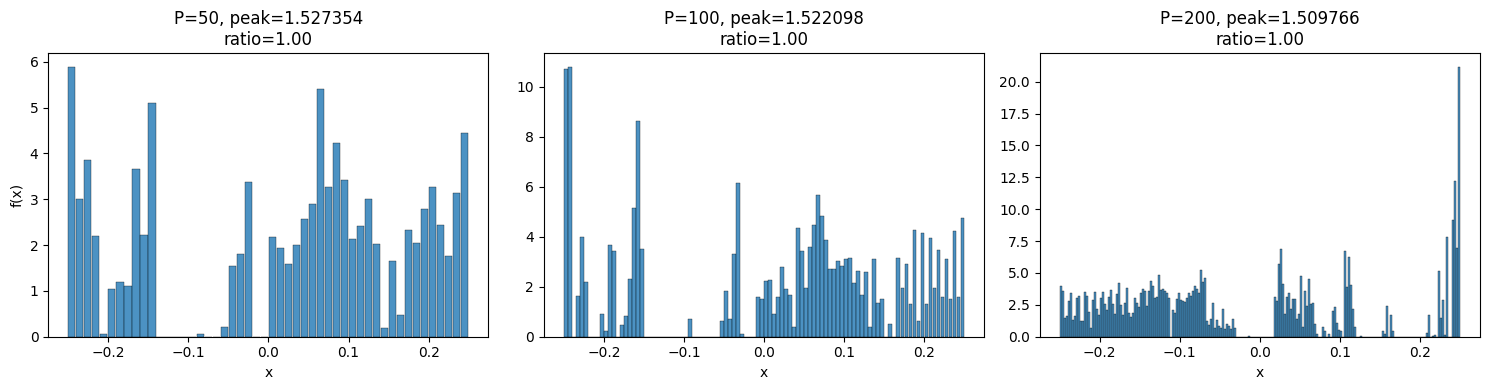

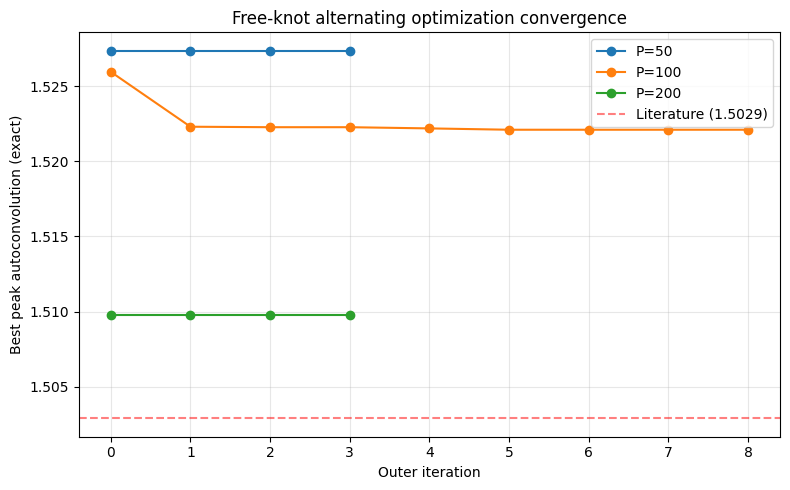

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, r in enumerate([result_50, result_100, result_200]):
    ax = axes[idx]
    e = r['edges']
    h = r['heights']
    w = np.diff(e)
    centers = 0.5 * (e[:-1] + e[1:])
    ax.bar(centers, h, width=w * 0.9, edgecolor='k', linewidth=0.3, alpha=0.8)
    ax.set_title(f'P={r["P"]}, peak={r["peak"]:.6f}\nratio={r["width_ratio"]:.2f}')
    ax.set_xlabel('x')
    if idx == 0:
        ax.set_ylabel('f(x)')

plt.tight_layout()
plt.savefig('free_knot_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Convergence history (running best)
fig, ax = plt.subplots(figsize=(8, 5))
for r in [result_50, result_100, result_200]:
    iters = [h['iter'] for h in r['history']]
    running_best = np.minimum.accumulate([h['best_peak'] for h in r['history']])
    ax.plot(iters, running_best, 'o-', label=f'P={r["P"]}')

ax.axhline(1.5029, color='r', ls='--', alpha=0.5, label='Literature (1.5029)')
ax.set_xlabel('Outer iteration')
ax.set_ylabel('Best peak autoconvolution (exact)')
ax.set_title('Free-knot alternating optimization convergence')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('free_knot_convergence.png', dpi=150, bbox_inches='tight')
plt.show()